<a href="https://colab.research.google.com/github/samarth-web/spotify-bigdata-analysis/blob/main/big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyspark pandas matplotlib


In [40]:
# from google.colab import files
# files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [4]:
!kaggle datasets download maharshipandya/-spotify-tracks-dataset


Dataset URL: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
License(s): ODbL-1.0
  0% 0.00/8.17M [00:00<?, ?B/s]
100% 8.17M/8.17M [00:00<00:00, 567MB/s]


In [5]:
!unzip /content/-spotify-tracks-dataset.zip -d spotify_data


Archive:  /content/-spotify-tracks-dataset.zip
  inflating: spotify_data/dataset.csv  


In [6]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder.appName("SpotifySparkHive").config("spark.sql.warehouse.dir", "./spark_warehouse").enableHiveSupport().getOrCreate())
spark

In [7]:
spark.sql("CREATE DATABASE IF NOT EXISTS spotify_music")
spark.sql("USE spotify_music")
spark.sql("SHOW DATABASES")

DataFrame[namespace: string]

In [8]:
path = "spotify_data/dataset.csv"

sp_read = spark.read.option("header", True).option("inferSchema", True).csv(path)


In [9]:
sp_read.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- track_genre: string (nullable = true)



In [10]:
sp_read.write.mode("overwrite").saveAsTable("spotify_tracks")

In [11]:
spark.sql("SHOW TABLES").show()

+-------------+--------------+-----------+
|    namespace|     tableName|isTemporary|
+-------------+--------------+-----------+
|spotify_music|spotify_tracks|      false|
+-------------+--------------+-----------+



In [12]:
spark.sql("SELECT * FROM spotify_tracks LIMIT 5")

DataFrame[_c0: int, track_id: string, artists: string, album_name: string, track_name: string, popularity: string, duration_ms: string, explicit: string, danceability: string, energy: string, key: string, loudness: string, mode: string, speechiness: string, acousticness: string, instrumentalness: double, liveness: string, valence: string, tempo: double, time_signature: double, track_genre: string]

**Exploratory Data Analysis**

1.) Average Dancibility of all Songs

In [13]:
spark.sql("SELECT AVG(danceability) as avg_dance FROM spotify_tracks").show()

+------------------+
|         avg_dance|
+------------------+
|31.798216588376423|
+------------------+



2.) Average Dancibility of songs by genre


In [14]:
from pyspark.sql import functions as F
numeric_cols = [
    "popularity", "duration_ms", "danceability", "energy",
    "loudness", "speechiness", "acousticness",
    "liveness", "valence", "tempo"
]
sp_new = sp_read

for col in numeric_cols:
  sp_new = sp_new.withColumn(col,F.col(col).cast("double"))


spark.sql("CREATE DATABASE IF NOT EXISTS spotify_music")
spark.sql("USE spotify_music")
sp_new.write.mode("overwrite").saveAsTable("spotify_tracks")


In [15]:
spark.table("spotify_tracks")

DataFrame[_c0: int, track_id: string, artists: string, album_name: string, track_name: string, popularity: double, duration_ms: double, explicit: string, danceability: double, energy: double, key: string, loudness: double, mode: string, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, time_signature: double, track_genre: string]

In [16]:
spark.sql("""
SELECT track_genre, ROUND(AVG(danceability),3) AS avg_dance, COUNT(*) AS n
FROM spotify_tracks
WHERE track_genre NOT RLIKE '^[0-9.\\-]+$'
GROUP BY track_genre
ORDER BY avg_dance DESC
""").show(truncate=False)

+--------------+---------+----+
|track_genre   |avg_dance|n   |
+--------------+---------+----+
|kids          |0.779    |1000|
|chicago-house |0.766    |999 |
|reggaeton     |0.759    |1000|
|latino        |0.757    |1000|
|reggae        |0.745    |1000|
|hip-hop       |0.736    |1000|
|dancehall     |0.734    |1000|
|minimal-techno|0.729    |1000|
|detroit-techno|0.723    |1000|
|latin         |0.722    |1000|
|children      |0.716    |1000|
|deep-house    |0.71     |1000|
|sad           |0.692    |1000|
|dance         |0.688    |1000|
|study         |0.685    |1000|
|techno        |0.684    |1000|
|j-dance       |0.681    |1000|
|funk          |0.678    |1000|
|disco         |0.677    |1000|
|afrobeat      |0.67     |1000|
+--------------+---------+----+
only showing top 20 rows



3.) Energy by genre

+-------------+----------+----+
|track_genre  |avg_energy|n   |
+-------------+----------+----+
|death-metal  |0.931     |1000|
|grindcore    |0.924     |1000|
|metalcore    |0.914     |1000|
|happy        |0.911     |1000|
|hardstyle    |0.901     |1000|
|drum-and-bass|0.877     |1000|
|black-metal  |0.875     |1000|
|heavy-metal  |0.874     |1000|
|party        |0.871     |1000|
|j-idol       |0.869     |1000|
+-------------+----------+----+



<Axes: title={'center': 'Top 10 Genres by Energy'}, ylabel='track_genre'>

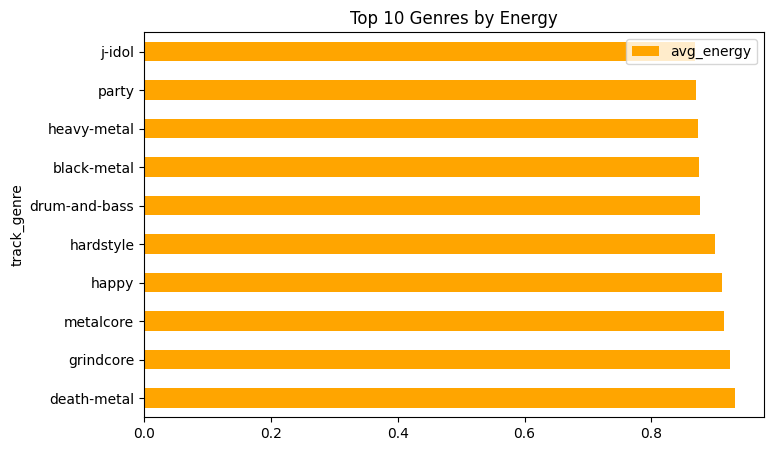

In [17]:
q2 = spark.sql("""
SELECT track_genre,
       ROUND(AVG(energy),3) AS avg_energy,
       COUNT(*) AS n
FROM spotify_tracks
WHERE track_genre NOT RLIKE '^[0-9.\\-]+$'
GROUP BY track_genre
HAVING n >= 100
ORDER BY avg_energy DESC
LIMIT 10
""")
q2.show(truncate=False)

pdf2 = q2.toPandas()
pdf2.plot(kind="barh", x="track_genre", y="avg_energy",
          title="Top 10 Genres by Energy", figsize=(8,5), color="orange")

4.) Corelation Energy and Loudness

+-----+
| corr|
+-----+
|0.007|
+-----+



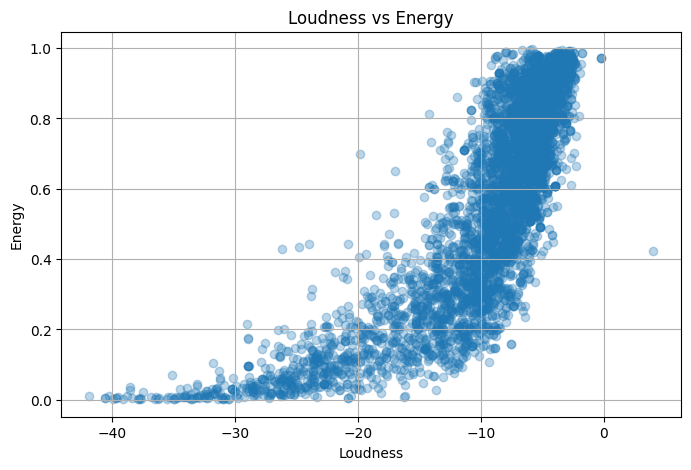

In [39]:
q4 = spark.sql("SELECT ROUND(CORR(loudness,energy),3) AS corr FROM spotify_tracks")
q4.show()

pdf4 = spark.sql("SELECT loudness, energy FROM spotify_tracks WHERE loudness IS NOT NULL AND energy IS NOT NULL LIMIT 5000").toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.scatter(pdf4["loudness"], pdf4["energy"], alpha=0.3)
plt.title("Loudness vs Energy")
plt.xlabel("Loudness")
plt.ylabel("Energy")
plt.grid(True)
plt.show()

Note on Loudness:
The 'loudness' feature in Spotify is measured in decibels (dB),using the LUFS (Loudness Units relative to Full Scale) standard. In digital audio, 0 dB represents the maximum possible loudness without distortion. Real tracks are always below this reference, so their loudness values are negative (e.g., -30 dB = quiet, -6 dB = loud/energetic). Negative values do NOT mean "negative volume" — they simply indicate how far below the maximum level the track is.

**Machine Learning - Predicting Genre of the Track**

In [19]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F
#the below steps are needed as to do ML on spark, there has to be a label column with numerical datatypes and all the features have to be combined into one column named 'features'

In [20]:
indexer = StringIndexer(inputCol="track_genre", outputCol="label", handleInvalid="skip") #converts the track_genre into a numerical label
indexed_df = indexer.fit(sp_new).transform(sp_new)


In [21]:
feature_cols = ["danceability","energy","loudness","speechiness",
                "acousticness","instrumentalness","liveness","valence",
                "tempo","popularity","duration_ms"]

# Drop rows with nulls in feature columns from the original DataFrame before assembling features
indexed_df_cleaned = indexed_df.na.drop(subset=feature_cols)

assembler = VectorAssembler(inputCols=feature_cols,outputCol='features')
sp_ml = assembler.transform(indexed_df_cleaned).select('features','label')

In [22]:
# Split the cleaned and assembled data
train, test = sp_ml.randomSplit([0.7,0.3], seed = 42)

In [23]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label',numTrees=200, seed=42)
# Drop rows with nulls from the training data before fitting the model
train_cleaned = train.na.drop()
model = rf.fit(train_cleaned)
pred = model.transform(test)

In [24]:
acc = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(pred)
f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(pred)
print(f"Accuracy: {acc}\nF1 Score: {f1}")

Accuracy: 0.1857624139446316
F1 Score: 0.13247883773585348


Full multi-class classification with 100+ fine-grained genres achieved 18% accuracy, which is significantly above random baseline of 1%. This highlights the difficulty of distinguishing niche genres from limited audio features.

In [25]:

df = sp_new

df = df.withColumn("is_pop", (F.col("track_genre") == "pop").cast("int"))
feature_cols = ["danceability","energy","loudness","speechiness",
                "acousticness","instrumentalness","liveness","valence",
                "tempo","popularity","duration_ms"]
df.groupBy("is_pop").count().show()

+------+------+
|is_pop| count|
+------+------+
|     0|113000|
|     1|  1000|
+------+------+



In [26]:



fractions = {0: 1000/113000, 1: 1.0}
balanced = df.sampleBy("is_pop", fractions, seed=42)

balanced.groupBy("is_pop").count().show()


+------+-----+
|is_pop|count|
+------+-----+
|     0| 1091|
|     1| 1000|
+------+-----+



In [27]:
train, test = balanced.randomSplit([0.7, 0.3], seed=42)

indexer = StringIndexer(inputCol="is_pop", outputCol="label", handleInvalid="skip")
train_i = indexer.fit(train).transform(train)
test_i  = indexer.fit(balanced).transform(test)

feature_cols = ["danceability","energy","loudness","speechiness",
                "acousticness","instrumentalness","liveness","valence",
                "tempo","popularity","duration_ms"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
train_ml = assembler.transform(train_i).select("features","label")
test_ml  = assembler.transform(test_i).select("features","label")


In [28]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label",
                            numTrees=200, maxDepth=12, featureSubsetStrategy="sqrt", seed=42)

model = rf.fit(train_ml)
pred  = model.transform(test_ml)

In [29]:
acc = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(pred)
f1  = MulticlassClassificationEvaluator(metricName="f1").evaluate(pred)

print("Accuracy:", round(acc,3), "F1:", round(f1,3))


Accuracy: 0.891 F1: 0.891
